E-Commerce Repeat Purchase Analysis

Setup and Imports 

In [7]:
# Standard libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook display options
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid", palette="crest")

# Load processed Parquet data
customers = pd.read_parquet("../data/processed/customers_clean.parquet")
orders = pd.read_parquet("../data/processed/orders_clean.parquet")
order_items = pd.read_parquet("../data/processed/order_items_clean.parquet")
products = pd.read_parquet("../data/processed/products_clean.parquet")

print(customers.shape, orders.shape, order_items.shape, products.shape)

(50, 7) (100, 4) (303, 4) (20, 5)


Identify Repeat Customers

In [2]:
# Count number of orders per customer
repeat_counts = orders.groupby("customer_id")["order_id"].nunique().reset_index()
repeat_counts.rename(columns={"order_id": "order_count"}, inplace=True)

# Flag repeat vs one-time
repeat_counts["is_repeat"] = repeat_counts["order_count"] > 1
repeat_counts.head()

,customer_id,order_count,is_repeat
0,2,1,False
1,3,3,True
2,4,3,True
3,5,2,True
4,6,4,True


 Merge Orders, Order Items & Products

In [8]:
# Merge dataframes for full order details
merged = (
    orders.merge(order_items, on="order_id")
          .merge(products, on="product_id")
          .merge(repeat_counts, on="customer_id")
)

# Compute revenue per item
merged["revenue"] = merged["quantity"] * merged["price"]
merged.head()

,order_id,customer_id,order_date,status,product_id,quantity,total_price,product_name,category,price,stock,order_count,is_repeat,revenue
0,1,4,2025-05-10,Cancelled,11,2,120.42,Tonight,Home,60.21,200,3,True,120.42
1,1,4,2025-05-10,Cancelled,18,2,233.0,Paper,Electronics,116.5,192,3,True,233.0
2,1,4,2025-05-10,Cancelled,4,2,65.38,Truth,Books,32.69,33,3,True,65.38
3,1,4,2025-05-10,Cancelled,19,3,1330.8,Rock,Clothing,443.6,58,3,True,1330.8
4,2,24,2025-01-07,Delivered,10,2,952.88,Brother,Electronics,476.44,121,3,True,952.88


Analyze Category Performance by Repeat Customers

In [4]:
category_summary = (
    merged.groupby(["category", "is_repeat"])
    .agg(total_revenue=("revenue", "sum"),
         avg_order_value=("revenue", "mean"),
         customers=("customer_id", "nunique"))
    .reset_index()
)

category_summary

,category,is_repeat,total_revenue,avg_order_value,customers
0,Books,False,237.33,59.3325,4
1,Books,True,2849.74,69.505854,22
2,Clothing,False,2792.15,698.0375,3
3,Clothing,True,35269.77,839.756429,22
4,Electronics,False,7066.26,543.558462,10
5,Electronics,True,41634.15,501.616265,26
6,Home,False,4115.47,342.955833,9
7,Home,True,18890.45,281.947015,25
8,Sports,False,6062.04,505.17,9
9,Sports,True,12280.96,491.2384,17


Visualization — Repeat vs One-Time Revenue by Category

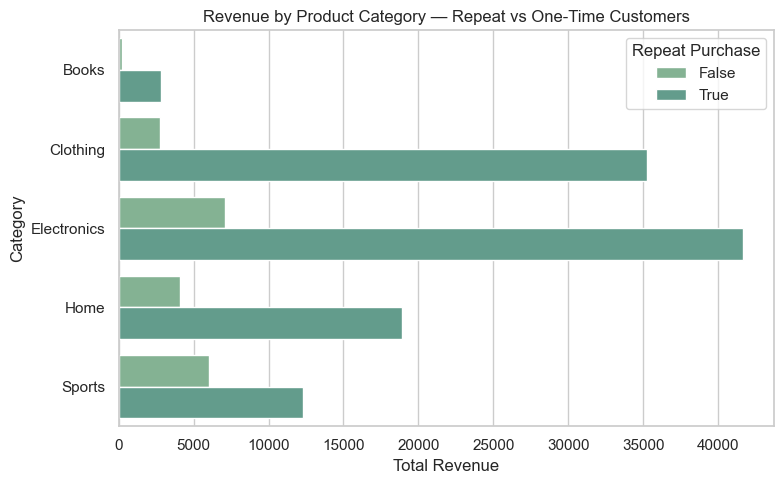

In [9]:
plt.figure(figsize=(8,5))
sns.barplot(data=category_summary, x="total_revenue", y="category", hue="is_repeat")
plt.title("Revenue by Product Category — Repeat vs One-Time Customers")
plt.xlabel("Total Revenue")
plt.ylabel("Category")
plt.legend(title="Repeat Purchase")
plt.tight_layout()
plt.show()

Visualization — Repeat Rate by Category

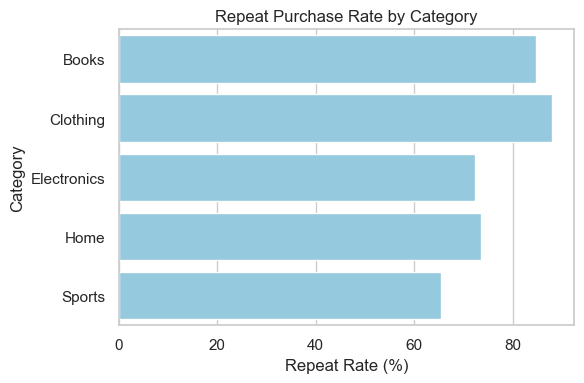

is_repeat,False,True,repeat_rate_%
category,,,
Clothing,3,22,88.000000
Books,4,22,84.615385
Home,9,25,73.529412
Electronics,10,26,72.222222
Sports,9,17,65.384615


In [6]:
repeat_rate = (
    category_summary.pivot(index="category", columns="is_repeat", values="customers")
    .fillna(0)
)
repeat_rate["repeat_rate_%"] = (
    repeat_rate[True] / (repeat_rate[True] + repeat_rate[False])
) * 100

plt.figure(figsize=(6,4))
sns.barplot(x=repeat_rate["repeat_rate_%"], y=repeat_rate.index, color="skyblue")
plt.title("Repeat Purchase Rate by Category")
plt.xlabel("Repeat Rate (%)")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

repeat_rate.sort_values("repeat_rate_%", ascending=False)